In [13]:
from src.utilities import create_entity, predict_and_save, split_data
from src.preprocess import process_missing_values, main_preprocess
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_ipcw
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis, GradientBoostingSurvivalAnalysis
import lightgbm as lgb

import warnings
import logging

# Régler le logger de Featuretools au niveau ERROR
logging.getLogger('featuretools.entityset').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",message=".*Ill-conditioned matrix.*")

data = create_entity()

# Specify the columns to be processed
save = False

training_size = 0.7
clinical_process = ["CYTOGENETICS"] # Possible: ["CYTOGENETICS", "HB/PLT"]
molecular_process = ["GENE", "END-START"] # Possible: ["GENE", "EFFECT", "ALT", "REF", "END-START"]
merge_process = ["featuretools"] # Possible: ["featuretools"]

data = main_preprocess(data, clinical_process, molecular_process, merge_process)
X, X_eval, y = split_data(data)
# Check if there are any columns that are not float or int in X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - training_size), random_state=42)

X_train, X_test, X_eval = process_missing_values(X_train, X_test, X_eval, method="impute", strategy="median")
# Ensure all columns in X_train are either float or int


In [12]:
xgb = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.1, max_depth=4, random_state=0)
xgb.fit(X_train, y_train)
cox_cindex_train = concordance_index_ipcw(y_train, y_train, xgb.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, xgb.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")


Cox Proportional Hazard Model Concordance Index IPCW on train: 0.82
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.70


In [14]:
scores_cph_tree = {}
predict_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(learning_rate=0.05, max_depth=2, random_state=0)
for i in range(1, 31):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)
    predict_cph_tree[n_estimators] = concordance_index_ipcw(y_train, y_test, est_cph_tree.predict(X_test), tau=7)[0]

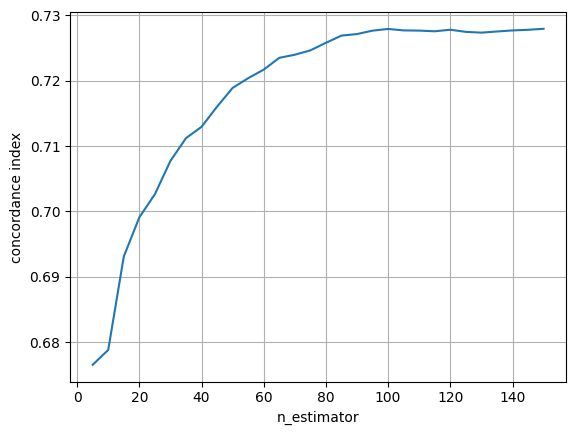

In [15]:
import matplotlib.pyplot as plt
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

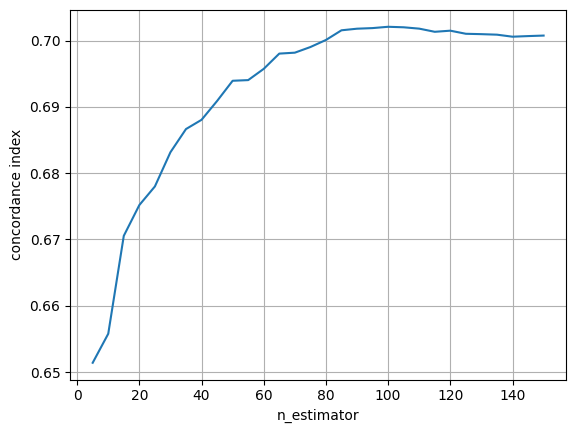

In [16]:
x, y = zip(*predict_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [17]:
scores_cph_ls = {}
predict_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(learning_rate=1.0, random_state=0)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)
    predict_cph_ls[n_estimators] = concordance_index_ipcw(y_train, y_test, est_cph_ls.predict(X_test), tau=7)[0]

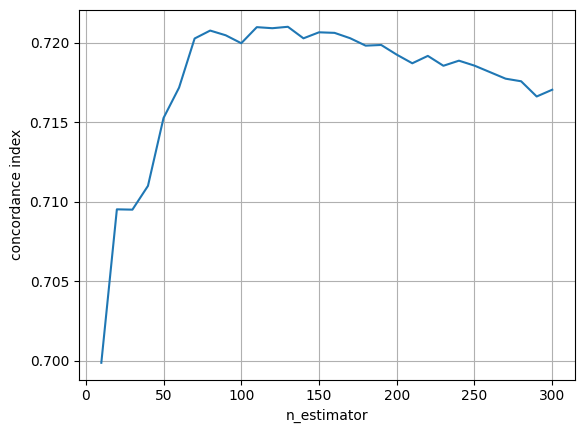

In [18]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)


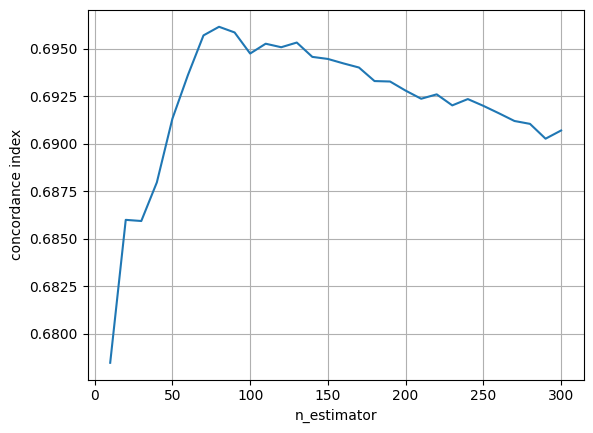

In [19]:
x, y = zip(*predict_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)


In [48]:
import pandas as pd

n_estimators = [100 + i * 5 for i in range(1, 31)]

estimators = {
    "lr5": GradientBoostingSurvivalAnalysis(learning_rate=0.035, subsample=0.5, max_depth=2, random_state=0),
    "lr6": GradientBoostingSurvivalAnalysis(learning_rate=0.04, subsample=0.5, max_depth=2, random_state=0),
    "lr7": GradientBoostingSurvivalAnalysis(learning_rate=0.045, subsample=0.5, max_depth=2, random_state=0),
    "lr8": GradientBoostingSurvivalAnalysis(learning_rate=0.05, subsample=0.5, max_depth=2, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
predict_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)
        predict_reg[name].append(concordance_index_ipcw(y_train, y_test, est.predict(X_test), tau=7)[0])

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)
predict_reg = pd.DataFrame(predict_reg, index=n_estimators)

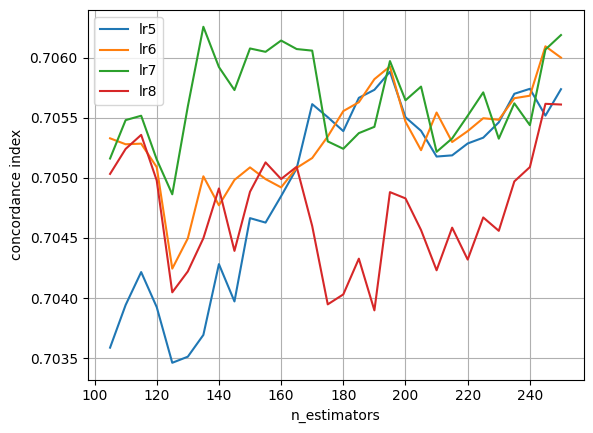

In [49]:
ax = predict_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

In [27]:
import pandas as pd

n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "max_depth2": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=2, random_state=0),
    "max_depth3": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=3, random_state=0),
    "max_depth4": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=4, random_state=0),
    "max_depth5": GradientBoostingSurvivalAnalysis(learning_rate=0.1, max_depth=5, random_state=0),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

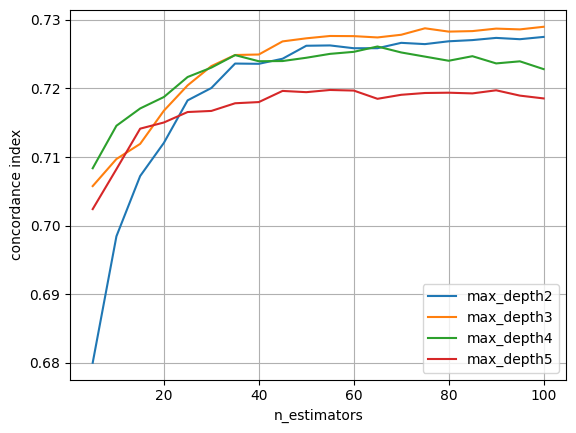

In [28]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

In [ ]:
import numpy as np

class EarlyStoppingMonitor:
    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        # continue training for first self.window_size iterations
        if iteration < self.window_size:
            return False

        # compute average improvement in last self.window_size iterations.
        # oob_improvement_ is the different in negative log partial likelihood
        # between the previous and current iteration.
        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  # continue fitting

        # stop fitting if there was no improvement
        # in last max_iter_without_improvement iterations
        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5, max_depth=2, random_state=0
)

monitor = EarlyStoppingMonitor(10, 5)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

In [1]:
from src.utilities import create_entity, predict_and_save, split_data
from src.preprocess import process_missing_values, main_preprocess
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_ipcw
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import lightgbm as lgb

import warnings
import logging

# Régler le logger de Featuretools au niveau ERROR
logging.getLogger('featuretools.entityset').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",message=".*Ill-conditioned matrix.*")

data = create_entity()

# Specify the columns to be processed
save = True

training_size = 0.7
clinical_process = ["CYTOGENETICS"] # Possible: ["CYTOGENETICS", "HB/PLT", "logMONOCYTES", "logWBC", "logANC"]
molecular_process = []#["GENE", "END-START"] # Possible: ["GENE", "EFFECT", "ALT", "REF", "END-START"]
merge_process = ["gpt"] # Possible: ["featuretools", "gpt"]

data = main_preprocess(data, clinical_process, molecular_process, merge_process)
X, X_eval, y = split_data(data)
# Check if there are any columns that are not float or int in X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - training_size), random_state=42)

X_train, X_test, X_eval = process_missing_values(X_train, X_test, X_eval, method="impute", strategy="median")
# Ensure all columns in X_train are either float or int

##############################################
# Define the methods used for training
##############################################

size_method = f"size_{training_size}"
clinical_method = "clinical_" + "_".join(clinical_process).replace("/", "divby")
molecular_method = "molecular_" + "_".join(molecular_process).replace("/", "divby")
merge_method = "merge_" + "_".join(merge_process).replace("/", "divby")

##############################################
# Fit a CoxPH model
##############################################

# Initialize and train the Cox Proportional Hazards model
cox = CoxPHSurvivalAnalysis()
cox.fit(X_train, y_train)

# Evaluate the model using Concordance Index IPCW
cox_cindex_train = concordance_index_ipcw(y_train, y_train, cox.predict(X_train), tau=7)[0]
cox_cindex_test = concordance_index_ipcw(y_train, y_test, cox.predict(X_test), tau=7)[0]
print(f"Cox Proportional Hazard Model Concordance Index IPCW on train: {cox_cindex_train:.2f}")
print(f"Cox Proportional Hazard Model Concordance Index IPCW on test: {cox_cindex_test:.2f}")
cox_score_method = f"score_{cox_cindex_train:.3f}_{cox_cindex_test:.3f}"

# Predict and save the results
if save:
    predict_and_save(X_eval, cox, method=f"{size_method}-{cox_score_method}-{clinical_method}-{molecular_method}-{merge_method}")


##############################################
# Fit a Gradient Boosting model
##############################################

xgb_params = {
    'max_depth': 2,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'subsample': 0.5,
}

xgb_params_method = "_".join([(str(key) + "=" + str(xgb_params[key])) for key in xgb_params.keys()])

xgb = GradientBoostingSurvivalAnalysis(subsample=xgb_params['subsample'], n_estimators=xgb_params['n_estimators'], learning_rate=xgb_params['learning_rate'], max_depth=xgb_params['max_depth'], random_state=42)
xgb.fit(X_train, y_train)
xgb_cindex_train = concordance_index_ipcw(y_train, y_train, xgb.predict(X_train), tau=7)[0]
xgb_cindex_test = concordance_index_ipcw(y_train, y_test, xgb.predict(X_test), tau=7)[0]
print(f"Gradient Boosting Survival Model Concordance Index IPCW on train: {xgb_cindex_train:.2f}")
print(f"Gradient Boosting Survival Model Concordance Index IPCW on test: {xgb_cindex_test:.2f}")
xgboost_score_method = f"score_{xgb_cindex_train:.3f}_{xgb_cindex_test:.3f}"

# Define LightGBM parameters
lgbm_params = {
    'max_depth': 2,
    'learning_rate': 0.05,
    'n_estimators': 200,
    'subsample': 0.5,
    'verbose': 0
}

X_train_lgb = X_train  # Features for training
y_train_transformed = y_train['time']

# Create LightGBM dataset
train_dataset = lgb.Dataset(X_train_lgb, label=y_train_transformed)

# Train the LightGBM model
model = lgb.train(params=lgbm_params, train_set=train_dataset)

# Evaluate the model using Concordance Index IPCW
train_ci_ipcw = concordance_index_ipcw(y_train, y_train, -model.predict(X_train), tau=7)[0]
test_ci_ipcw = concordance_index_ipcw(y_train, y_test, -model.predict(X_test), tau=7)[0]
print(f"LightGBM Survival Model Concordance Index IPCW on train: {train_ci_ipcw:.2f}")
print(f"LightGBM Survival Model Concordance Index IPCW on test: {test_ci_ipcw:.2f}")
lightgbm_score_method = f"score_{train_ci_ipcw:.3f}_{test_ci_ipcw:.3f}"

Cox Proportional Hazard Model Concordance Index IPCW on train: 0.71
Cox Proportional Hazard Model Concordance Index IPCW on test: 0.69
Gradient Boosting Survival Model Concordance Index IPCW on train: 0.74
Gradient Boosting Survival Model Concordance Index IPCW on test: 0.70
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [2]:
X_train.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

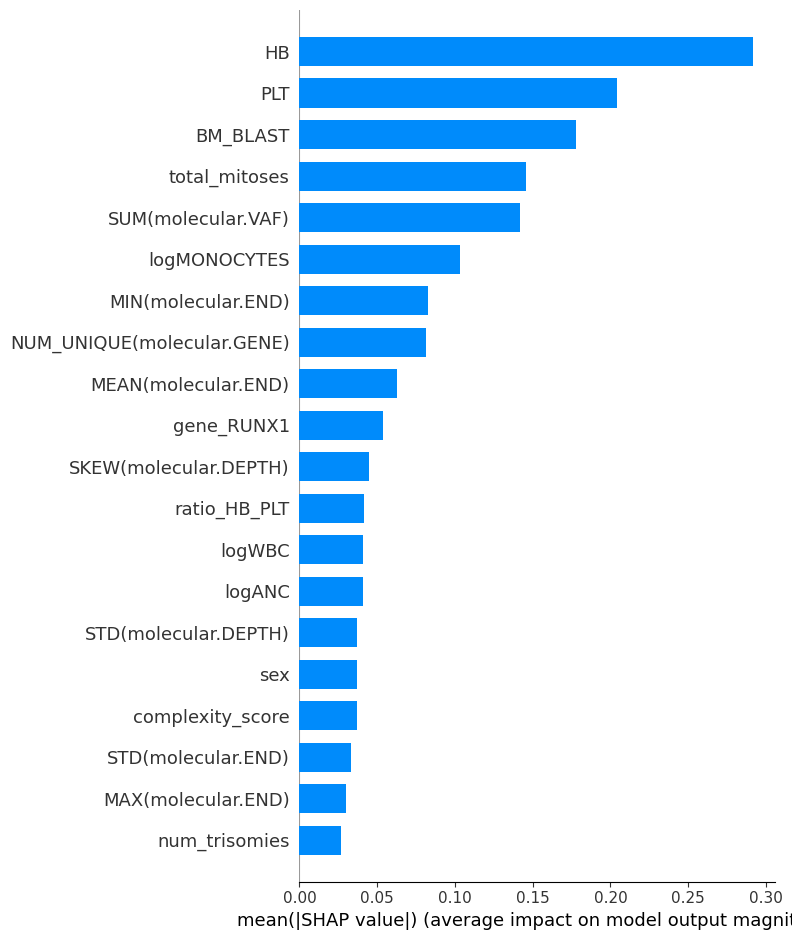

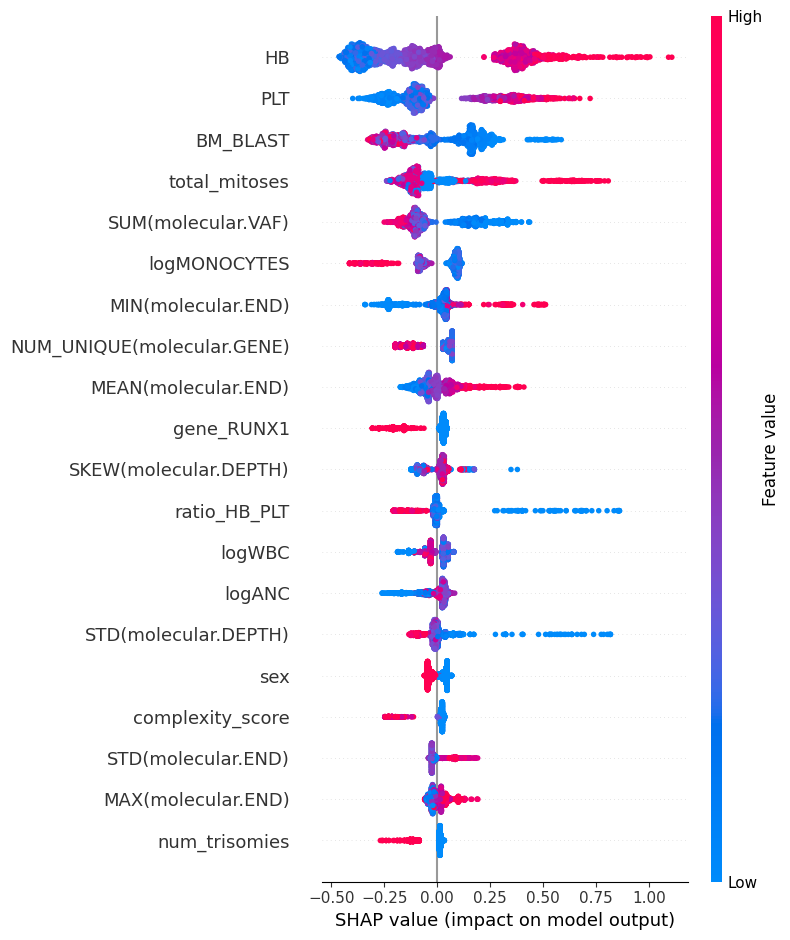

In [3]:
import numpy as np
import pandas as pd
import shap

# 2) Create the SHAP Explainer using that function and a background dataset
explainer = shap.Explainer(model)

# Assurez-vous que X_train est un DataFrame
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=X.columns)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")
shap.summary_plot(shap_values, X_train)

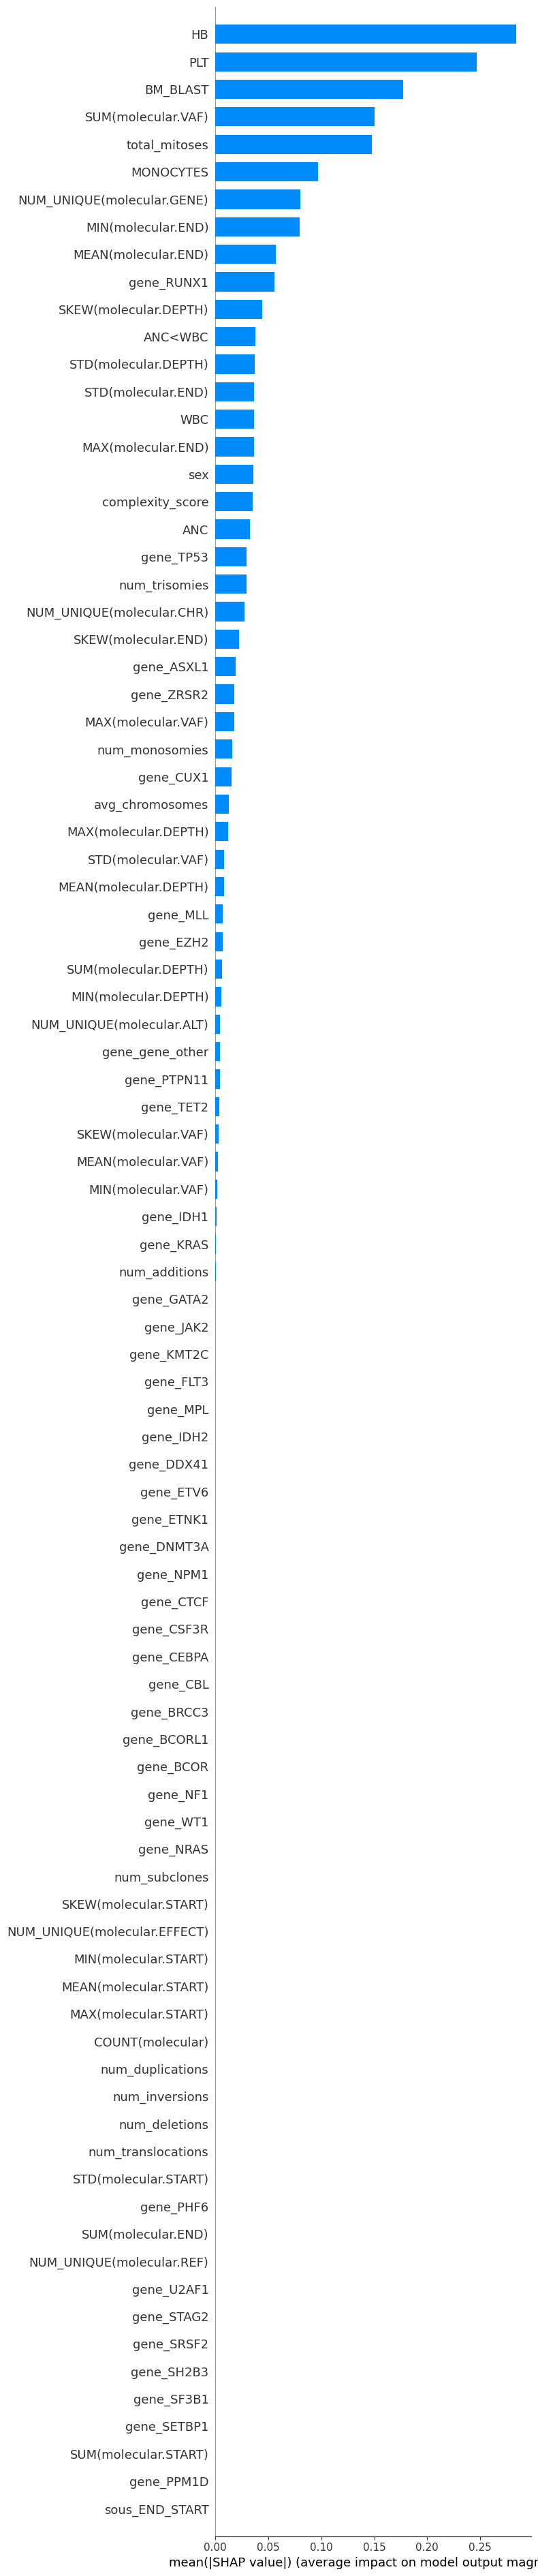

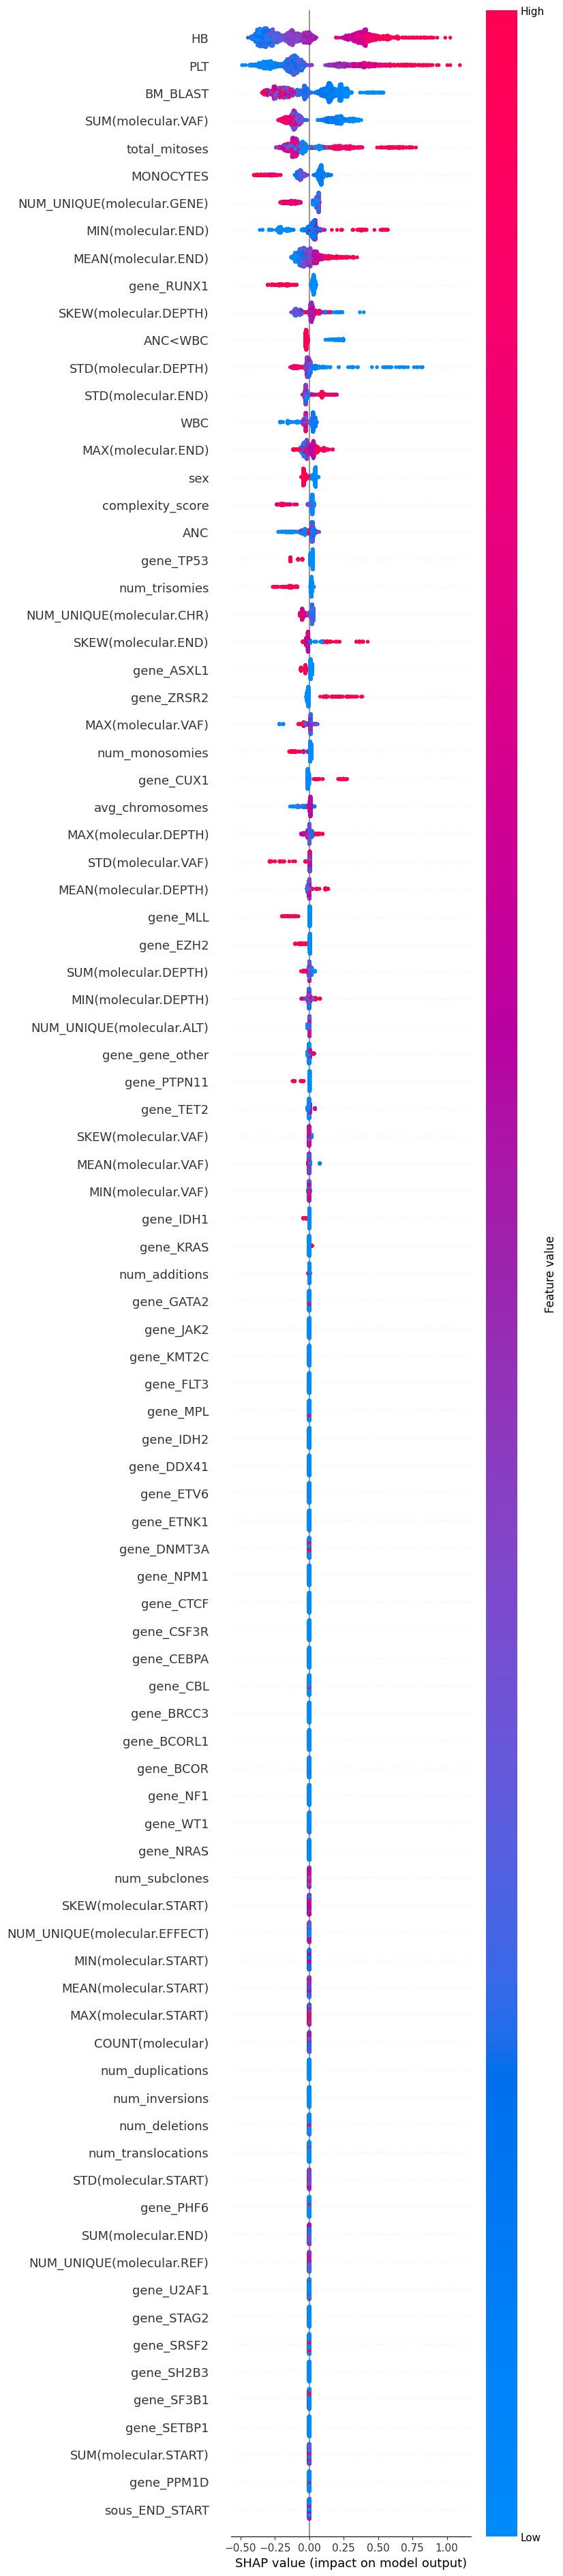

In [10]:
import numpy as np
import pandas as pd
import shap

# 2) Create the SHAP Explainer using that function and a background dataset
explainer = shap.Explainer(model)

# Assurez-vous que X_train est un DataFrame
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=X.columns)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=100)
shap.summary_plot(shap_values, X_train, max_display=100)

PermutationExplainer explainer: 2222it [00:43, 39.87it/s]                          


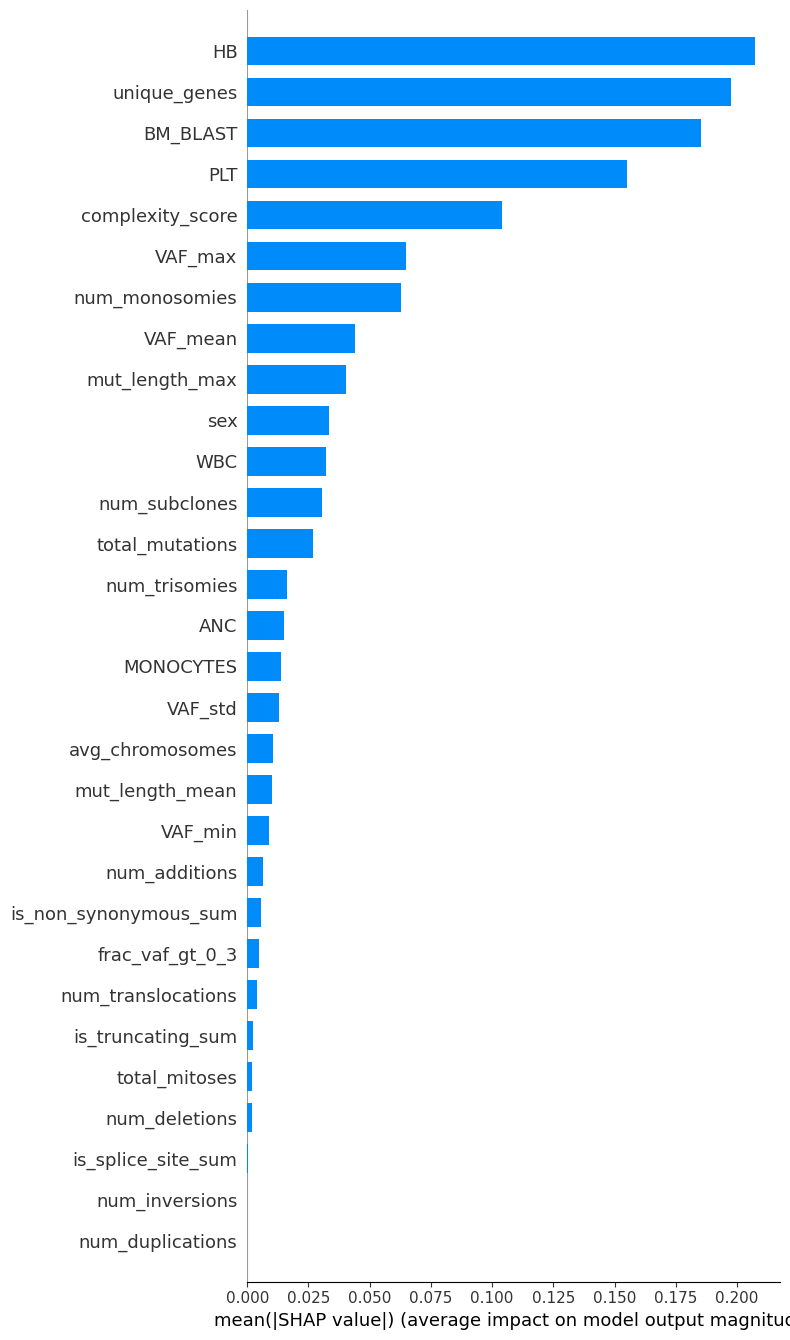

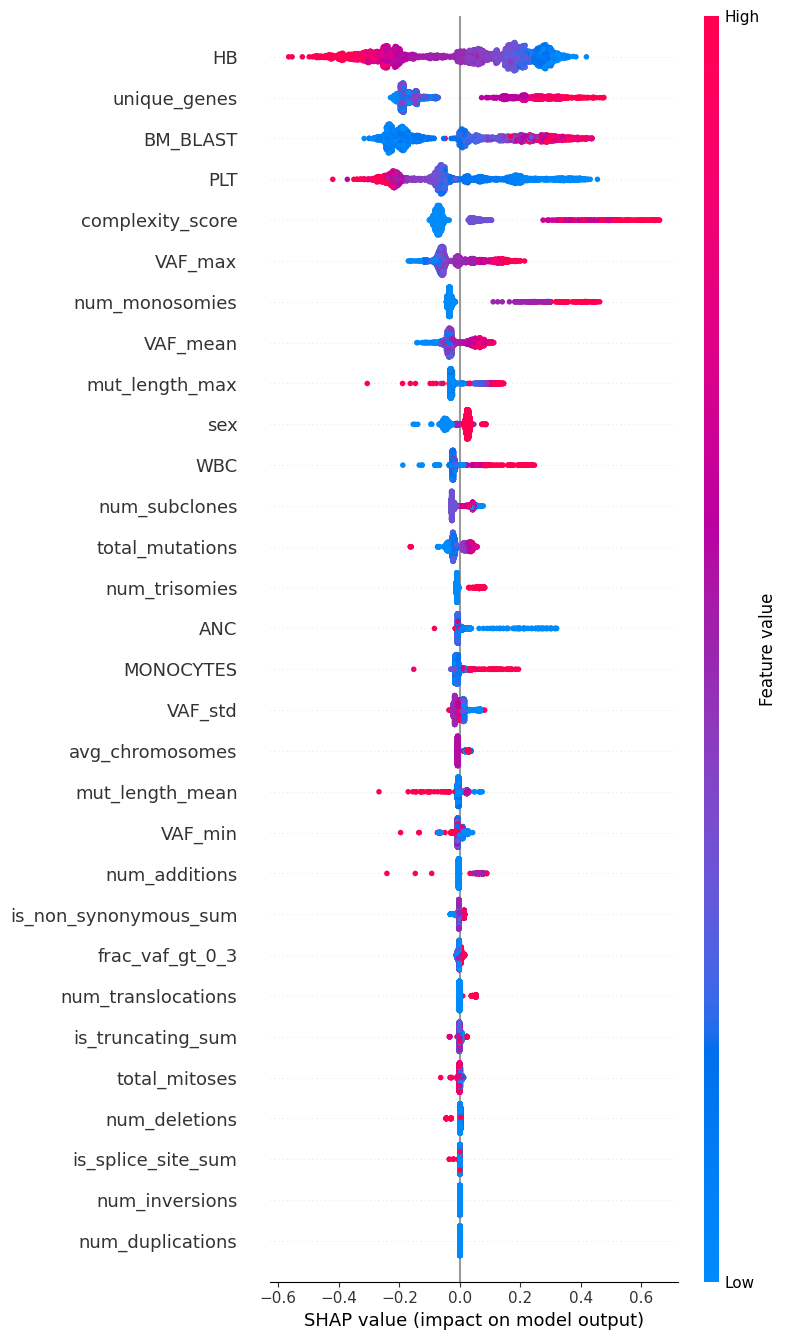

In [2]:
import numpy as np
import pandas as pd
import shap

# 1) Define a simple Python function that uses xgb.predict()
#    This is what SHAP will actually call internally.
def predict_function(data):
    # data will come in as a numpy array or DataFrame
    # Make sure you pass it to .predict() in the same format
    # you used for training. If X_train was a DataFrame, you might
    # need to wrap data in a DataFrame with the same columns:
    if isinstance(data, np.ndarray):
        data = pd.DataFrame(data, columns=X_train.columns)
    return xgb.predict(data)

# 2) Create the SHAP Explainer using that function and a background dataset
explainer = shap.Explainer(predict_function, X_train)

# Assurez-vous que X_train est un DataFrame
if isinstance(X_train, np.ndarray):
    X_train = pd.DataFrame(X_train, columns=X.columns)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=100)
shap.summary_plot(shap_values, X_train, max_display=100)

In [3]:
X_train

NameError: name 'X_train' is not defined

In [3]:
shap.plots.heatmap(
    shap_values, 
    max_display=20
)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [15]:
from src.utilities import create_entity, predict_and_save, split_data
from src.preprocess import process_missing_values, main_preprocess
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_ipcw
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import lightgbm as lgb

import warnings
import logging

# Régler le logger de Featuretools au niveau ERROR
logging.getLogger('featuretools.entityset').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",message=".*Ill-conditioned matrix.*")

data = create_entity()

# Specify the columns to be processed
save = True

training_size = 0.7
clinical_process = ["CYTOGENETICS"] # Possible: ["CYTOGENETICS", "HB/PLT", "logMONOCYTES", "logWBC", "logANC"]
molecular_process = ["GENE", "END-START"] # Possible: ["GENE", "EFFECT", "ALT", "REF", "END-START"]
merge_process = ["featuretools"] # Possible: ["featuretools", "gpt"]

data = main_preprocess(data, clinical_process, molecular_process, merge_process)
X, X_eval, y = split_data(data)
# Check if there are any columns that are not float or int in X

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - training_size), random_state=42)

X_train, X_test, X_eval = process_missing_values(X_train, X_test, X_eval, method="impute", strategy="median")





In [16]:
y_train

array([(False, 1.91780822), ( True, 1.28219178), ( True, 1.49041096), ...,
       (False, 8.63561644), (False, 0.47671233), (False, 1.29041096)],
      shape=(2221,), dtype=[('event', '?'), ('time', '<f8')])

In [13]:
import pandas as pd

df_y = pd.DataFrame(y_train)
df_X = pd.DataFrame(X_train, columns=X.columns)

# merge on index
df = pd.merge(df_X, df_y, left_index=True, right_index=True)

In [17]:
df.sample(5)

,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,num_subclones,sex,avg_chromosomes,total_mitoses,num_translocations,num_deletions,num_inversions,num_duplications,num_additions,num_monosomies,num_trisomies,complexity_score,VAF_mean,VAF_max,VAF_min,VAF_std,is_truncating_sum,is_non_synonymous_sum,is_splice_site_sum,mut_length_mean,mut_length_max,total_mutations,unique_genes,frac_vaf_gt_0_3,event,time
778,4.0,7.51,4.36,0.75,13.500,67.0,2.0,0.0,46.0,13.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.462006,-1.651228,-0.653253,0.019743,-0.984128,-0.585953,-0.344382,-0.314221,-0.307746,-1.134445,-1.119334,-1.395384,False,2.572603
1984,0.0,6.90,5.60,0.36,10.149,321.0,1.0,0.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.102981,-1.391518,-0.334450,0.019743,-0.297410,-1.395258,-0.344382,-0.043259,-0.223686,-1.134445,-1.119334,-1.395384,False,2.128767
981,3.3,31.00,19.22,6.50,12.600,50.0,0.0,1.0,46.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.279416,1.874342,1.029466,0.799627,0.389309,0.223352,-0.344382,-0.246481,-0.223686,0.261935,0.593890,1.212453,True,0.076712
1168,2.0,8.90,5.52,0.53,10.400,380.0,1.0,0.0,46.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.089610,1.046600,-0.508098,0.830570,-0.297410,1.841963,-0.344382,0.444473,0.869094,0.727396,0.593890,0.169318,True,2.975342
264,1.0,3.60,1.40,0.33,11.400,67.0,2.0,0.0,46.0,13.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.108197,-0.039539,-0.536592,0.019743,-0.297410,0.223352,-0.344382,-0.223901,-0.223686,-0.203525,0.022815,-0.091465,True,8.057534


In [9]:
y

array([( True, 1.11506849), (False, 4.92876712), (False, 2.04383562), ...,
       (False, 1.99726027), ( True, 0.09589041), (False, 2.29041096)],
      shape=(3173,), dtype=[('event', '?'), ('time', '<f8')])

In [1]:
# Import AutoViz from the autoviz library for automated visualization of data
from autoviz import AutoViz_Class

Imported v0.1.905. Please call AutoViz in this sequence:
    AV = AutoViz_Class()
    %matplotlib inline
    dfte = AV.AutoViz(filename, sep=',', depVar='', dfte=None, header=0, verbose=1, lowess=False,
               chart_format='svg',max_rows_analyzed=150000,max_cols_analyzed=30, save_plot_dir=None)


In [ ]:
AV = AutoViz_Class()

In [2]:
y

NameError: name 'y' is not defined

In [1]:
from src.preprocess import parse_cytogenetics_column
import pandas as pd
df = pd.read_csv("data/X_train/clinical_train.csv")

df = parse_cytogenetics_column(df, column_name='CYTOGENETICS')

In [2]:
df.to_csv('data/Analyse.csv')

In [3]:
df

,ID,CENTER,BM_BLAST,WBC,ANC,MONOCYTES,HB,PLT,num_subclones,sex,avg_chromosomes,total_mitoses,num_translocations,num_deletions,num_inversions,num_duplications,num_additions,num_monosomies,num_trisomies,complexity_score
0,P132697,MSK,14.0,2.80,0.20,0.70,7.6,119.0,2,1.0,46.000000,20,0,1,0,0,0,0,0,1
1,P132698,MSK,1.0,7.40,2.40,0.10,11.6,42.0,1,NaN,46.000000,0,0,0,0,0,0,0,0,0
2,P116889,MSK,15.0,3.70,2.10,0.10,14.2,81.0,2,1.0,46.000000,20,1,0,0,0,0,0,0,1
3,P132699,MSK,1.0,3.90,1.90,0.10,8.9,77.0,2,1.0,46.000000,20,0,1,0,0,0,0,0,1
4,P132700,MSK,6.0,128.00,9.70,0.90,11.1,195.0,2,NaN,46.000000,20,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3318,P121828,VU,1.0,3.70,2.53,0.53,8.9,499.0,1,1.0,46.000000,20,0,0,0,0,0,0,0,0
3319,P121829,VU,0.0,4.20,2.40,0.22,10.6,49.0,3,1.0,45.666667,20,0,2,0,0,0,0,0,2
3320,P121830,VU,0.0,1.80,0.55,0.29,9.4,86.0,2,1.0,45.500000,20,0,1,0,0,0,1,0,1
3321,P121853,VU,5.0,1.37,0.37,0.11,11.4,102.0,4,NaN,45.750000,20,0,1,0,0,0,1,1,1


In [4]:
from src.utilities import create_entity, predict_and_save, split_data
from src.preprocess import process_missing_values, main_preprocess
from sklearn.model_selection import train_test_split
from sksurv.metrics import concordance_index_ipcw
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import lightgbm as lgb

import warnings
import logging

# Régler le logger de Featuretools au niveau ERROR
logging.getLogger('featuretools.entityset').setLevel(logging.ERROR)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore",message=".*Ill-conditioned matrix.*")

data = create_entity()

# Specify the columns to be processed
save = False

training_size = 0.7
clinical_process = ["CYTOGENETICS"] # Possible: ["CYTOGENETICS", "HB/PLT", "logMONOCYTES", "logWBC", "logANC"]
molecular_process = ["GENE", "END-START"] # Possible: ["GENE", "EFFECT", "ALT", "REF", "END-START"]
merge_process = ["featuretools"] # Possible: ["featuretools"]

data = main_preprocess(data, clinical_process, molecular_process, merge_process)
X, X_eval, y = split_data(data)
# Check if there are any columns that are not float or int in X

X_train_, X_test, y_train, y_test = train_test_split(X, y, test_size=(1 - training_size), random_state=42)

X_train, X_test, X_eval = process_missing_values(X_train_, X_test, X_eval, method="impute", strategy="median")

In [5]:
X_train

array([[3.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        4.07714249e+08, 4.07714246e+08, 1.99470000e+00],
       [7.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
        2.07288172e+08, 2.07288165e+08, 2.20930000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.59589910e+08, 1.59589910e+08, 8.36000000e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.70079907e+08, 2.70079907e+08, 7.77000000e-01],
       [2.00000000e+00, 1.00000000e+00, 0.00000000e+00, ...,
        2.43368816e+08, 2.43368814e+08, 1.29440000e+00],
       [2.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.37837050e+08, 1.37837048e+08, 1.20160000e+00]])

In [6]:
import pandas as pd

test = pd.DataFrame(X_train, columns=X.columns, index=X_train_.index)

In [8]:
test.columns

Index(['sous_END_START', 'gene_ASXL1', 'gene_BCOR', 'gene_BCORL1',
       'gene_BRCC3', 'gene_CBL', 'gene_CEBPA', 'gene_CSF3R', 'gene_CTCF',
       'gene_CUX1', 'gene_DDX41', 'gene_DNMT3A', 'gene_ETNK1', 'gene_ETV6',
       'gene_EZH2', 'gene_FLT3', 'gene_GATA2', 'gene_IDH1', 'gene_IDH2',
       'gene_JAK2', 'gene_KMT2C', 'gene_KRAS', 'gene_MLL', 'gene_MPL',
       'gene_NF1', 'gene_NPM1', 'gene_NRAS', 'gene_PHF6', 'gene_PPM1D',
       'gene_PTPN11', 'gene_RUNX1', 'gene_SETBP1', 'gene_SF3B1', 'gene_SH2B3',
       'gene_SRSF2', 'gene_STAG2', 'gene_TET2', 'gene_TP53', 'gene_U2AF1',
       'gene_WT1', 'gene_ZRSR2', 'gene_gene_other', 'BM_BLAST', 'WBC', 'ANC',
       'MONOCYTES', 'HB', 'PLT', 'num_subclones', 'sex', 'avg_chromosomes',
       'total_mitoses', 'num_translocations', 'num_deletions',
       'num_inversions', 'num_duplications', 'num_additions', 'num_monosomies',
       'num_trisomies', 'complexity_score', 'COUNT(molecular)',
       'MAX(molecular.DEPTH)', 'MAX(molecular.END)',